# Групповой анализ данных с учетом условий

In [123]:
%pylab inline
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.style.use('seaborn-whitegrid');

## Загрузка данных

Посмотрим данные испытуемого по имени C\* http://balatte.stireac.com/result/ssdanielyan%40mail.ru/

Он прошел тест в состоянии усталости и повторно после корректирующей процедуры.

In [3]:
udo = 'http://balatte.stireac.com/result.tsv/ssdanielyan%40mail.ru/sta194-1-r401-06.valeo.rsu.ru__6159522610000171030'
uposle = 'http://balatte.stireac.com/result.tsv/ssdanielyan%40mail.ru/sta194-1-r401-06.valeo.rsu.ru__7104549320000171030'
u=uposle
D1=pd.read_table(udo)
D2=pd.read_table(uposle)
D1.shape, D2.shape, 

((48, 2), (48, 2))

## Исходные данные

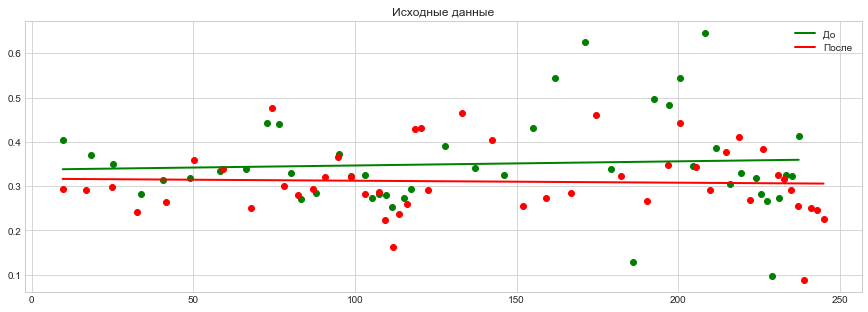

In [13]:
figsize(15,5);
plot(D1.t, D1.v, 'go', label='__none__')
plot(D2.t, D2.v, 'ro', label='__none__')

Dg=D1[isfinite(D1.v)]
xx=Dg.t.iloc[[0,-1]]
yy=polyval(polyfit(Dg.t,Dg.v,1), xx)
plot(xx,yy,'g',lw=2, label='До');

Dg=D2[isfinite(D2.v)]
xx=Dg.t.iloc[[0,-1]]
yy=polyval(polyfit(Dg.t,Dg.v,1), xx)
plot(xx,yy,'r',lw=2, label='После');

legend()
title('Исходные данные');

Почему тренд отличается от того, что на сайте?

Потому что на сайте удалены выбросы.

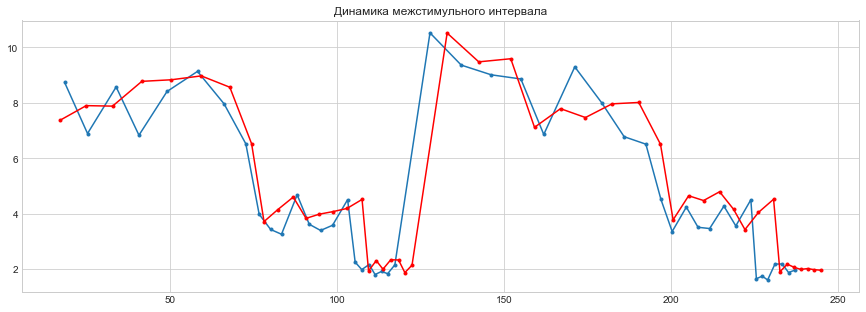

In [5]:
isi=diff(D1.t)
plot(D1.t[1:], isi,'.-')

isi=diff(D2.t)
plot(D2.t[1:], isi,'r.-')

title('Динамика межстимульного интервала');

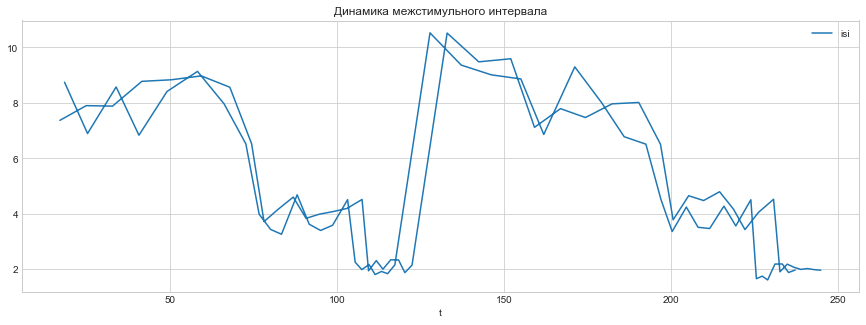

In [20]:
D1['isi']=D1.t.diff()
D1['condition'] = 'До'
D2['isi']=D2.t.diff()
D2['condition'] = 'После'

D = pd.concat([D1, D2], ignore_index=True, sort=False)
D

D.plot('t', 'isi', title='Динамика межстимульного интервала');

Добавим информацию о интервале и модальности.

In [90]:
isi0 = array([8,4,2])
momo = ['v','a']
nRep = D1.shape[0]//(len(isi0)*len(momo))
nCond = 2
D['isi'] = kron(isi0, ones((nCond,len(momo),nRep))).reshape((-1,1))
D['mod'] = tile(repeat(momo, nRep*len(isi0)), nCond)

g = D.groupby(['condition','mod','isi'])
g['v'].count()

condition  mod  isi
До         a    2.0    8
                4.0    8
                8.0    8
           v    2.0    7
                4.0    7
                8.0    8
После      a    2.0    8
                4.0    8
                8.0    8
           v    2.0    8
                4.0    8
                8.0    8
Name: v, dtype: int64

In [91]:
D.isi = pd.Categorical(D.isi.astype(int))

Получили 6 групп по 7-8 значений.

## Групповая статистика


### Вариант 1. numpy.array по параметрам

In [36]:
M=g.v.mean()
S=g.v.std()
N=g.v.count()

M=array(M).reshape(nCond, -1)
S=array(S).reshape(nCond, -1)
N=array(N).reshape(nCond, -1)

M

array([[0.4245    , 0.371     , 0.324125  , 0.299625  , 0.35171429,
        0.32771429],
       [0.31125   , 0.288875  , 0.34875   , 0.3035    , 0.326     ,
        0.282875  ]])

In [37]:
from scipy import stats
xx=arange(M.shape[1])
pp=[stats.ttest_ind_from_stats(M[0,i],S[0,i],N[0,i], M[1,i],S[1,i],N[1,i]).pvalue for i in xx]
# pp=[stats.ttest_ind(gg[i],gg[i+3])[1] for i in xx]
pp

[0.047887330646352165,
 0.11356068396811606,
 0.7162257527782102,
 0.8754279029830861,
 0.5386943756926235,
 0.15554138040610416]

### Вариант 2. numpy.array по подвыборкам

In [92]:
gg=[]
for _i,_g in g:
    gg.append(_g.v.dropna())

In [93]:
pp=[]
for i in range(M.shape[1]):
    pp.append(stats.ttest_ind(gg[i],gg[i+M.shape[1]], nan_policy='omit').pvalue)
pp

[0.3690906431234954,
 0.09623013949940312,
 0.4441021357319478,
 0.8501772924924738,
 0.538390741332816,
 0.033121057652250166]

In [94]:
pp=[stats.ttest_ind(gg[i],gg[i+M.shape[1]], equal_var=False)[1] for i in range(M.shape[1])]
pp

[0.3696627171141421,
 0.10449040647409953,
 0.44715557863811495,
 0.8424489768576318,
 0.540696967330092,
 0.03328861661166986]

Мы получили 6 p-values. Всего один результат находится на границе значимости. 

Значимость различий адекватно оценивается при выборках большего размера. Однако, при повторе одного и того же анализа на соседних выборках нужно использовать поправки на множественные сравнения.

In [95]:
import statsmodels.stats.multitest as multitest
multitest.multipletests(pp, method='fdr_bh')

(array([False, False, False, False, False, False]),
 array([0.64883636, 0.31347122, 0.64883636, 0.84244898, 0.64883636,
        0.1997317 ]),
 0.008512444610847103,
 0.008333333333333333)

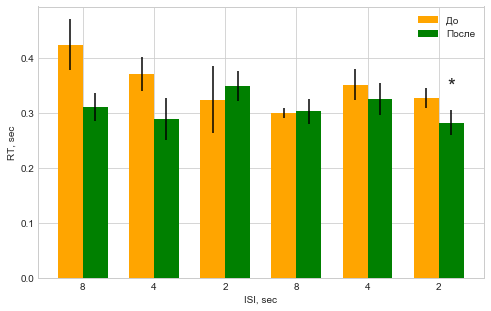

In [96]:
figsize(8,5)

SEM=S/sqrt(N)
width = 0.35 #ширина столбцов
p1 = bar(xx-width, M[0], width, color='orange', yerr=SEM[0])
p2 = bar(xx, M[1], width, color='green', yerr=SEM[1])
xticks(xx-width/2, tile(isi0,2))
xlabel('ISI, sec')
ylabel('RT, sec')
legend(['До','После'])

for i,p in enumerate(pp):
    if p<0.05:
        text(xx[i], max(M[:,i])+0.01, '*', size=20, horizontalalignment='center')

### Вариант 3. ANOVA с влиянием факторов

In [97]:
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

In [98]:
mo = sm.OLS.from_formula('v ~ condition + mod + isi + condition:mod', D).fit()
mo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      v   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     5.951
Date:                Fri, 12 Apr 2019   Prob (F-statistic):           8.71e-05
Time:                        16:19:38   Log-Likelihood:                 102.77
No. Observations:                  94   AIC:                            -193.5
Df Residuals:                      88   BIC:                            -178.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.3206      0.021     15.231      0.000       0.279       0.362
condition[T.После]             -0.0569      0.024     -2.353      0.021      -0.105      -0.009
mod[T.v]                       -0.0486      0.025     -1.964      0.053      -0.098       0.001
isi[T.4]                        0.0940      0.021      4.417      0.000       0.052       0.136
isi[T.8]                        0.0639      0.021      3.026      0.003       0.022       0.106
condition[T.После]:mod[T.v]     0.0364      0.035      1.052      0.296      -0.032       0.105
==============================================================================
Omnibus:                        7.764   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               12.254
Skew:                           0.275   Prob(JB):                      0.00218
Kurtosis:                       4.681   Cond. No.                         7.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
anova_lm(mo)

,df,sum_sq,mean_sq,F,PR(>F)
condition,1.0,0.037600,0.037600,5.353142,0.023015
mod,1.0,0.020738,0.020738,2.952536,0.089259
isi,2.0,0.142876,0.071438,10.170697,0.000106
condition:mod,1.0,0.007779,0.007779,1.107480,0.295511
Residual,88.0,0.618104,0.007024,NaN,NaN


В последней колонке искомые p-values.

Чтобы понять как работают линейные модели с категориальными факторами, отобразим матрицу дизайна.

Все сочетания уровней действующих факторов кодируются сочетаниями нулей и единиц.

In [101]:
mo.model.exog_names

['Intercept',
 'condition[T.После]',
 'mod[T.v]',
 'isi[T.4]',
 'isi[T.8]',
 'condition[T.После]:mod[T.v]']

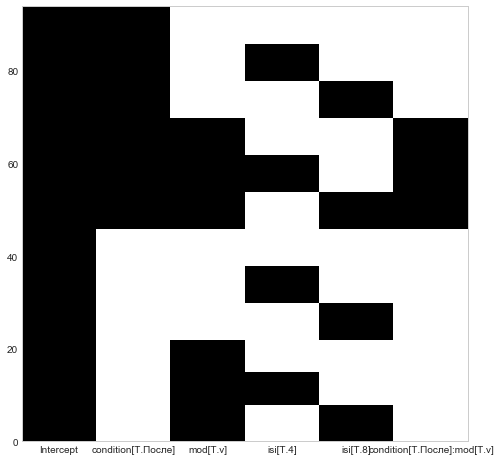

In [110]:
figure(figsize=(8,8))
pcolor(mo.model.exog);
xticks(arange(6)+.5, mo.model.exog_names);

Для кодирования фактора с двумя уровнями достаточно одной колонки. Для кодирования МСИ с 3 уровнями задействованы две колонки: МСИ=2 кодируется двумя нулями в колонках для isi=4 и isi=8.

## Групповые рисунки

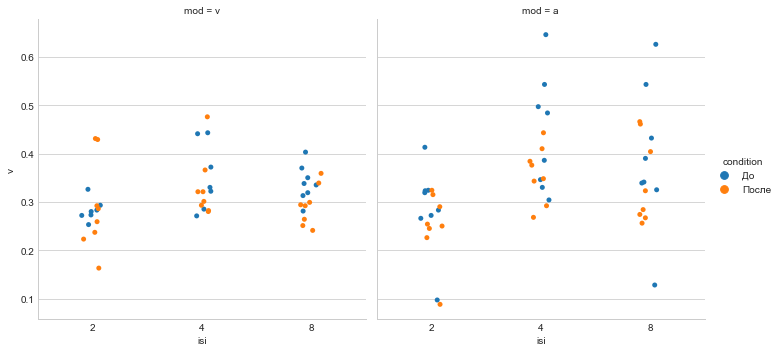

In [125]:
sns.catplot('isi','v', 'condition', D, col='mod');

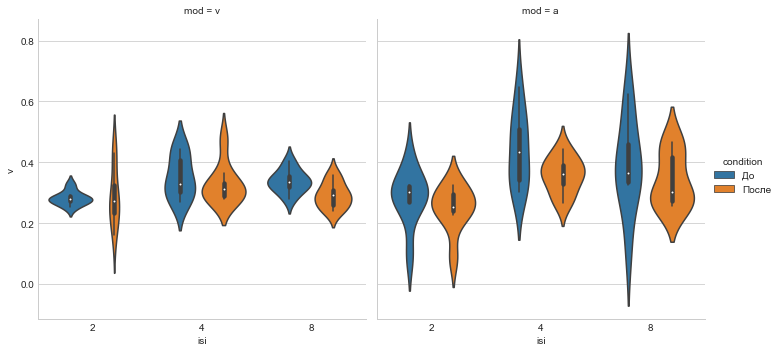

In [130]:
sns.catplot('isi','v', 'condition', D, col='mod', kind='violin');

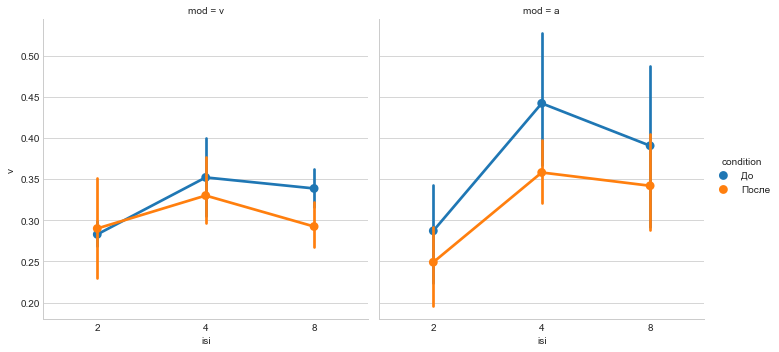

In [131]:
sns.catplot('isi','v', 'condition', D, col='mod', kind='point');

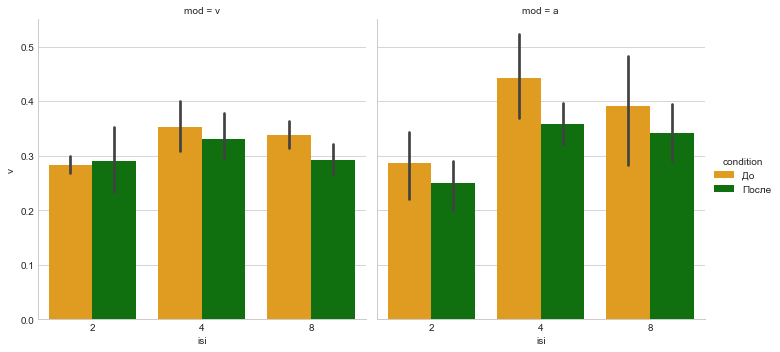

In [132]:
pal = {'До':'orange', 'После':'green'}
sns.catplot('isi','v', 'condition', D, col='mod', kind='bar', palette=pal);